In [74]:
import idx2numpy as id2np
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset


In [75]:

images=id2np.convert_from_file('train-images.idx3-ubyte')
labels=id2np.convert_from_file('train-labels.idx1-ubyte')
test_images=id2np.convert_from_file('t10k-images.idx3-ubyte')
test_labels=id2np.convert_from_file('t10k-labels.idx1-ubyte')

##### reading images as 28 * 28 matrices and their labels as numpy arrays

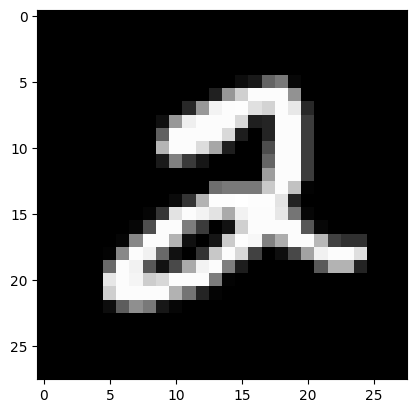

In [76]:
from matplotlib import pyplot as plt
plt.gray()
plt.imshow(images[5])
plt.show()

In [77]:
train_images = images / 255.0
test_data = test_images / 255.0
  
from collections import Counter
train_data,validation_data, train_labels, validation_labels = train_test_split(train_images,labels, test_size=1/6,random_state=42)
print("Training images shape:", train_data.shape)
print("Training labels shape:", train_labels.shape)
print("Test images shape:", validation_data.shape)
print("Test labels shape:", validation_labels.shape)
print("Test images shape:", test_data.shape)
print("Test labels shape:", test_labels.shape)
counter=Counter(train_labels)
print(counter)


Training images shape: (50000, 28, 28)
Training labels shape: (50000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)
Counter({1: 5649, 7: 5205, 3: 5131, 2: 4964, 9: 4939, 0: 4939, 6: 4937, 8: 4872, 4: 4862, 5: 4502})


##### Preprocessing Data:
- already grey scaled pixels are normalized to have values between 0 and 1
- data is split randomly into training and validation portions
- counter is made to check if training data has a balanced distribution  

In [78]:


train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(validation_data, dtype=torch.float32)
test_tensor = torch.tensor(test_data, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(validation_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_tensor, test_labels_tensor)



##### each of the numpy arrays representing training,validation and test data become tensors and are grouped with their labels into datasets


In [79]:
import torch.nn as nn  
import torch.nn.functional as F 
class FeedForwardNN(nn.Module):
    def __init__(self,hidden_layers):
        super(FeedForwardNN, self).__init__()  
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(28*28,hidden_layers[0]))
        for i in range(1,len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.layers.append(nn.Linear(hidden_layers[-1],10))    
    def forward(self, x):  
        if x.dim() > 2:
            x = x.view(-1,28*28)
    
        for i, layer in enumerate(self.layers[:-1]): 
            x = F.relu(layer(x))

        x = self.layers[-1](x)

        return x  
    

##### Custom Feed Forward Neural Network Class:
- network can have a dynamic amount of hidden layers and neurons per layer as specified by the user
- it uses rectified linear unit as an activation function between the hidden layers
- it flattens the data into two dimensions implicitly for use in forward pass

In [80]:
def validate_network(network,val_loader,loss_function):
    network.eval() 
    val_loss = 0
    correct = 0 
    total = 0 
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = network(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total  
    avg_val_loss = val_loss / len(val_loader) 
    return avg_val_loss, val_accuracy  

In [85]:
def train_network(network,train_loader,val_loader,optimizer,loss_function):
    train_losses = [] 
    train_accuracies = []  
    val_losses = [] 
    val_accuracies = [] 
    EPOCHS=25
    for e in range(EPOCHS):
        network.train()
        current_loss=0
        correct_prediction=0
        total_processed=0
        for images,labels in train_loader:
            predictions=network(images)
            loss=loss_function(predictions,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            current_loss+=loss.item()
            _, predicted = torch.max(predictions, 1)
            correct_prediction += (predicted == labels).sum().item()
            total_processed += labels.size(0)
        avg_train_loss = current_loss / len(train_loader)  
        train_accuracy = correct_prediction / total_processed  
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_loss, val_accuracy = validate_network(network,val_loader,loss_function)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    return train_losses,train_accuracies,val_losses,val_accuracies



##### Custom training function:
- loops over data EPOCH times
- processes training data in batches doing a forward pass on each batch
- uses loss function (Cross Entropy) to optimize weights and biases by backpropagation
- backpropagation uses the optimizer SGD in this case to choose best weights and biases
- after each epoch network is tested against validation data to check for generalization

In [82]:
def plot_metrics(train_losses, train_accuracies,val_losses , val_accuracies, epochs=25):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label='Train Loss')
    plt.plot(range(epochs), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()


Training with learning rate: 1


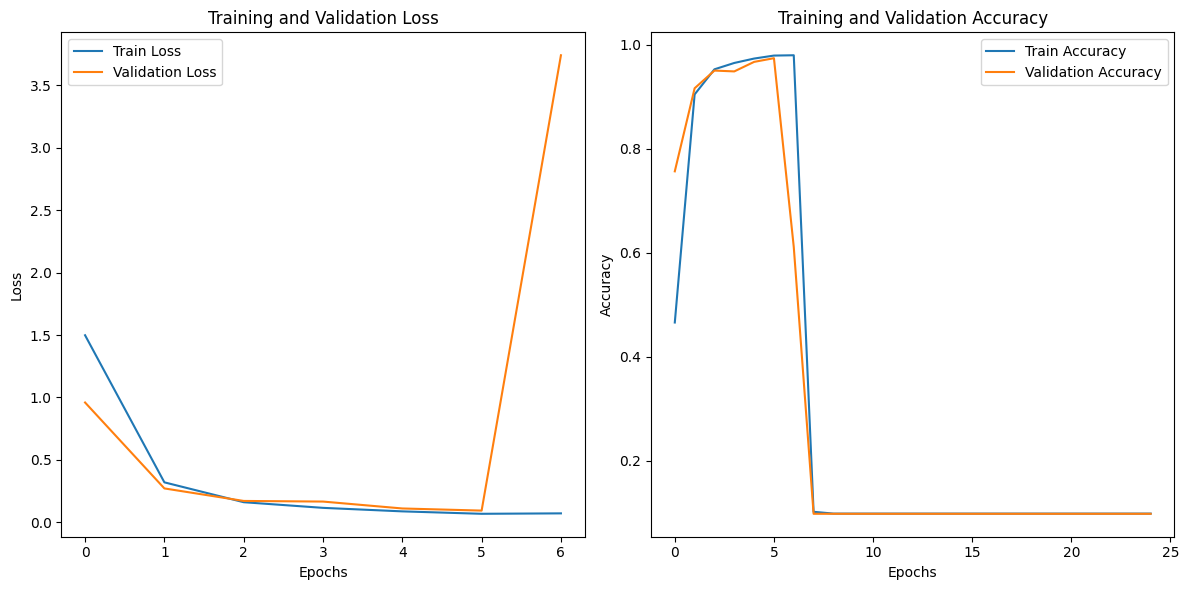

Training with learning rate: 0.1


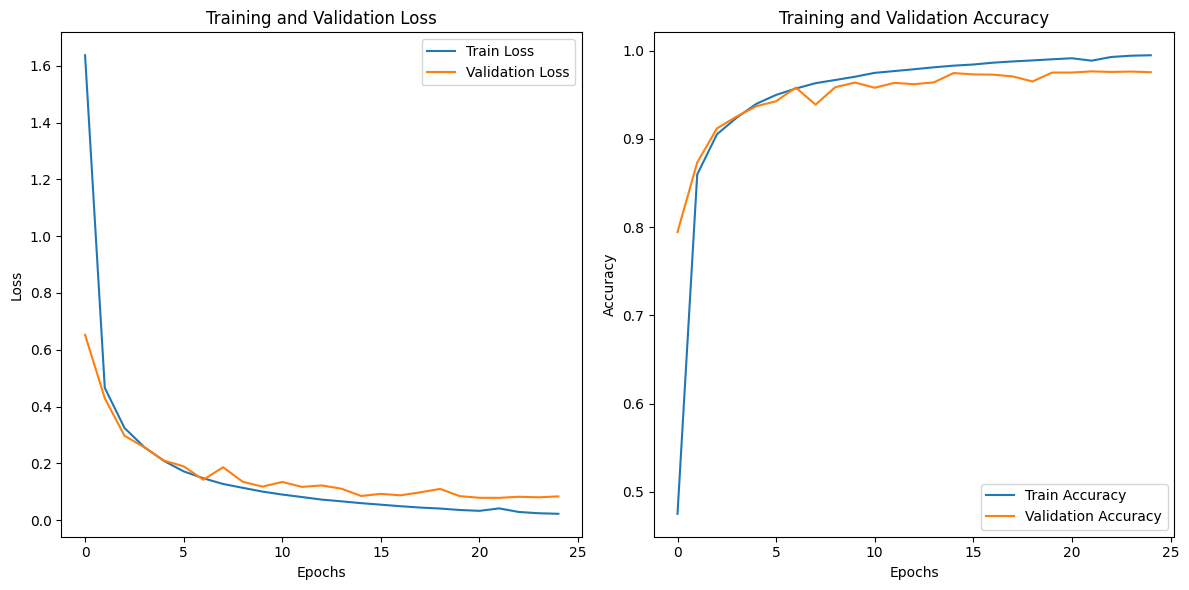

Training with learning rate: 0.01


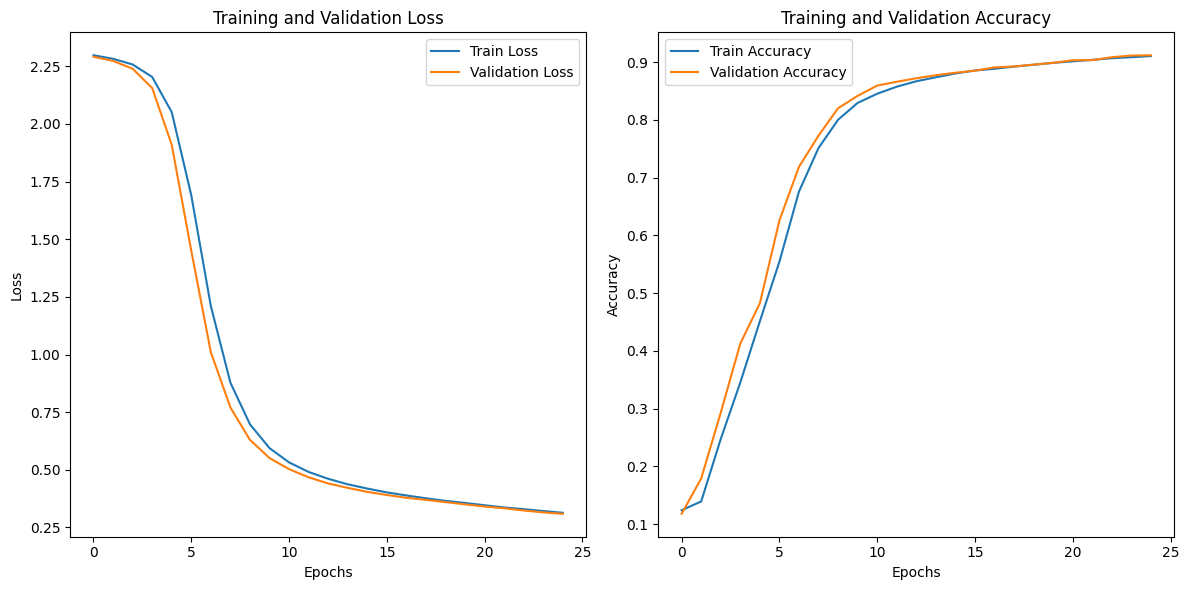

Training with learning rate: 0.001


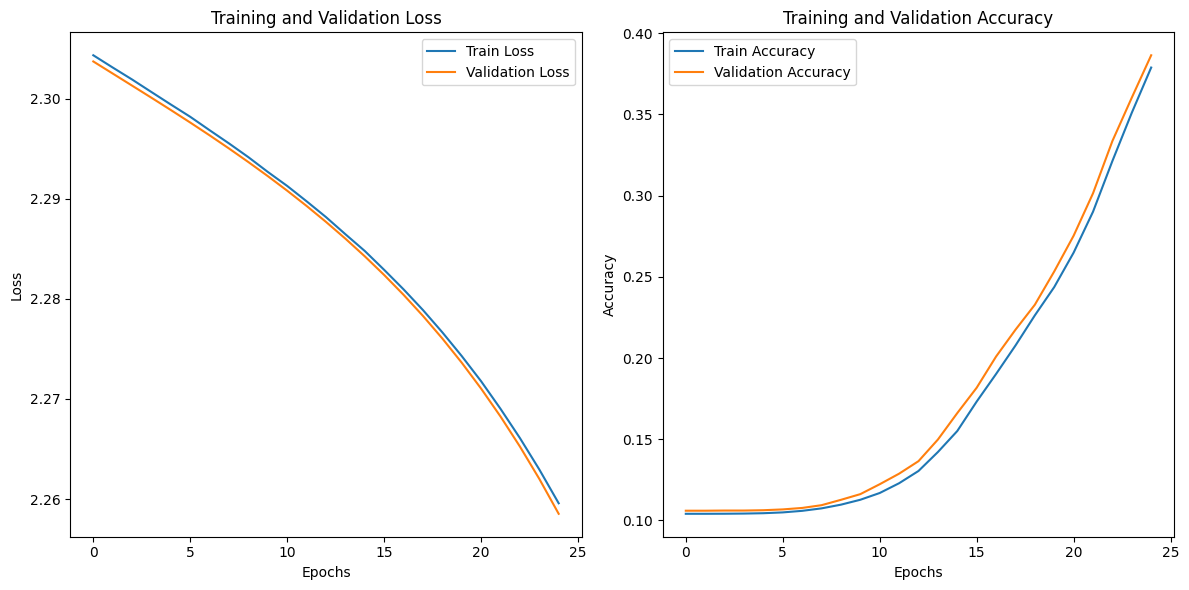

Training with learning rate: 0.0001


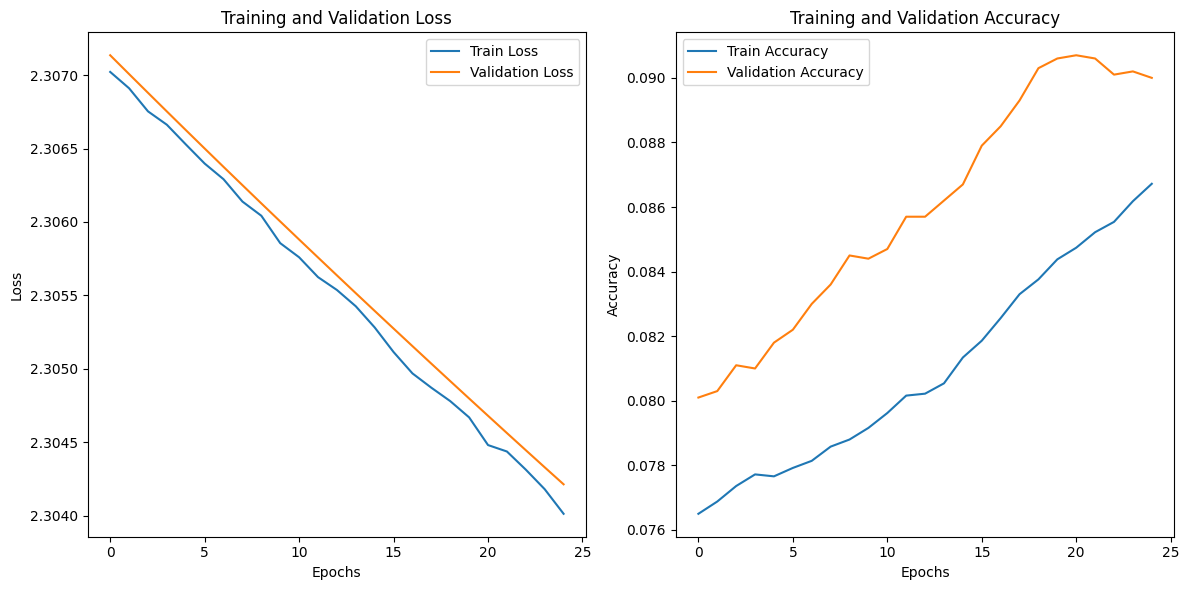


Best Learning Rate:
Learning Rate: 0.1, Validation Accuracy: 0.9764


In [ ]:

learning_rates=[1,0.1,0.01,0.001,0.0001]
results = {}
batch_size=256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
for a in learning_rates:
    network = FeedForwardNN([256,128,64])
    print(f"Training with learning rate: {a}")
    train_losses,train_accuracies,val_losses,val_accuracies = train_network(network,train_loader,val_loader,torch.optim.SGD(network.parameters(), lr=a),nn.CrossEntropyLoss())
    plot_metrics(train_losses,train_accuracies,val_losses,val_accuracies)
    best_val_accuracy = max(val_accuracies)
    results[a] = best_val_accuracy

best_lr = max(results, key=results.get)

print("\nBest Learning Rate:")
print(f"Learning Rate: {best_lr}, Validation Accuracy: {results[best_lr]:.4f}")



##### Testing different learning rates:
- loss and accuracy are calculated at each epoch for multiple learning rates for training data and then optimizations are made
- loss and accuracy are calculated at each epoch for multiple learning rates for validation data to check generalization
- the learning rate with the highest validation accuracy is selected for future use   

Training with batch size: 512


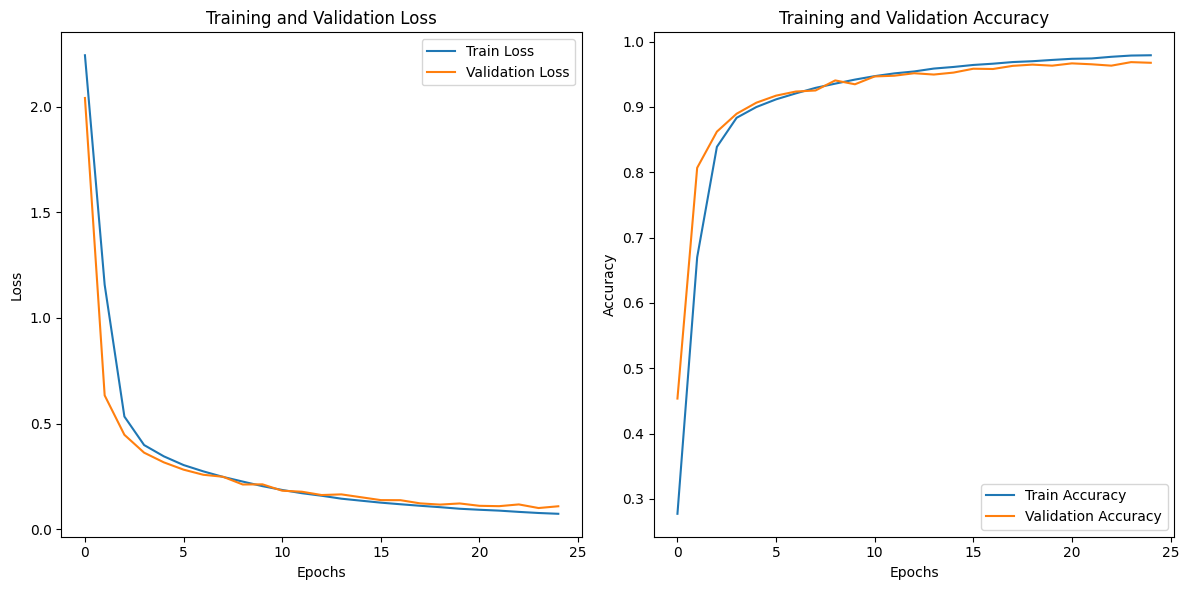

Best accuracy: 0.9685


Training with batch size: 256


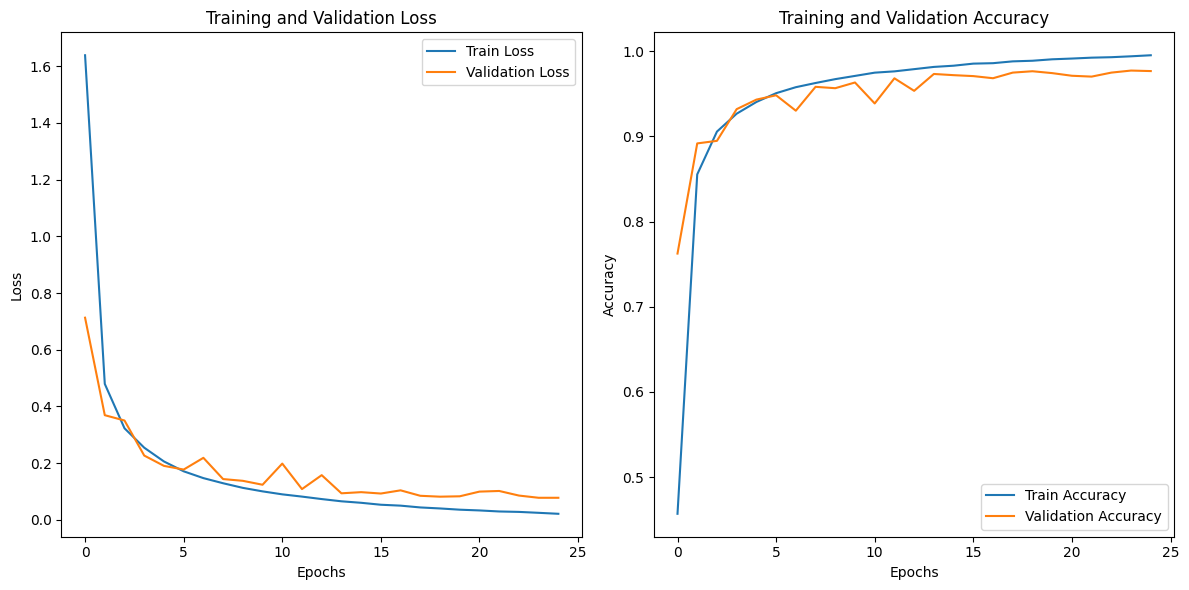

Best accuracy: 0.9772


Training with batch size: 128


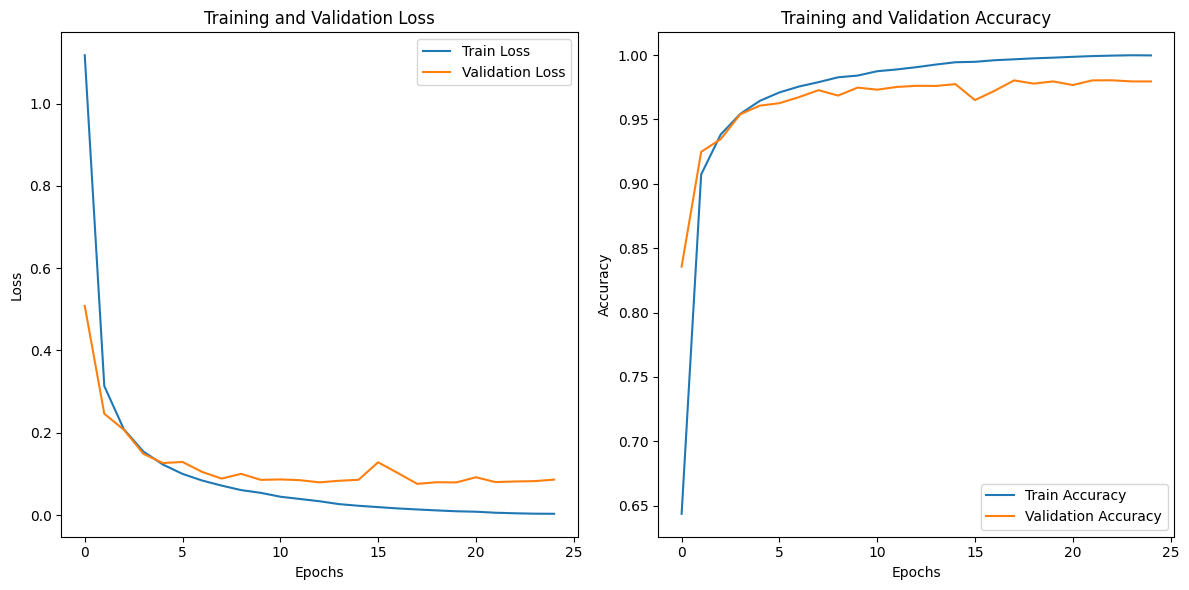

Best accuracy: 0.9804


Training with batch size: 64


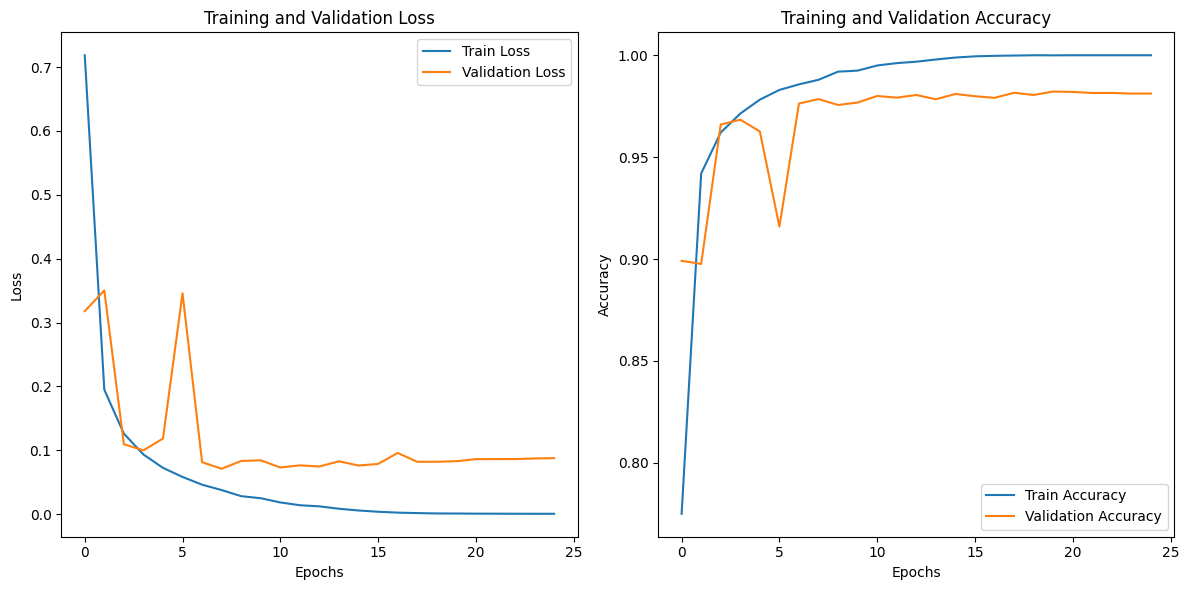

Best accuracy: 0.9822


Training with batch size: 32


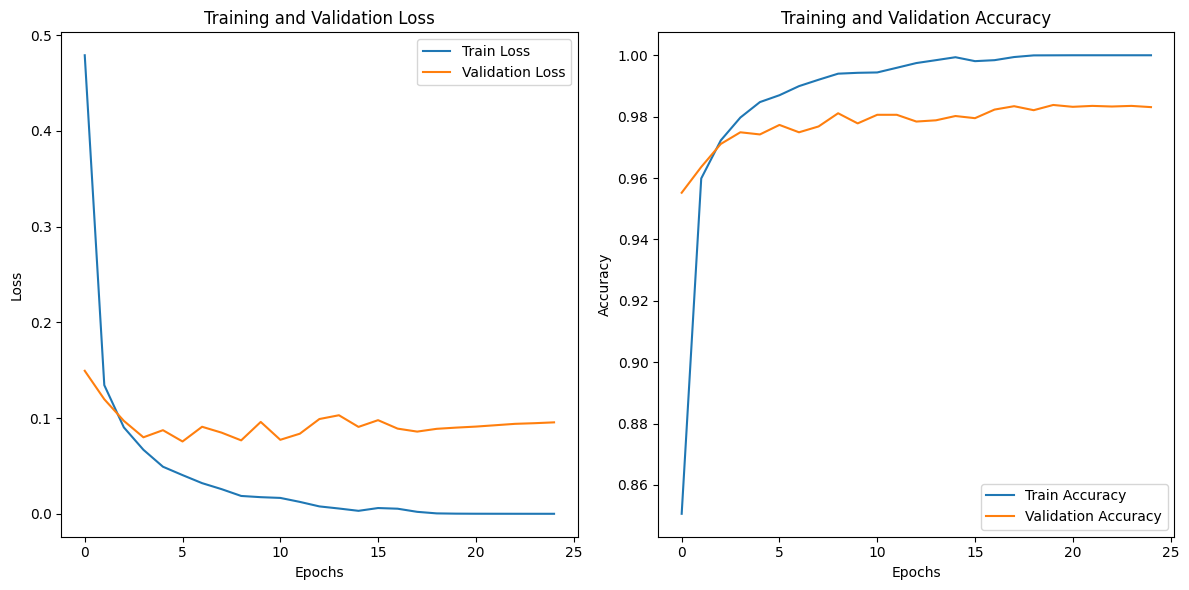

Best accuracy: 0.9838



Best bacth size:
batch size: 32, Validation Accuracy: 0.9838


In [89]:
batch_sizes=[512,256,128,64,32]
results = {}

for b in batch_sizes:
    train_loader = DataLoader(train_dataset, batch_size=b, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=b, shuffle=False)
    network = FeedForwardNN([256,128,64])
    print(f"Training with batch size: {b}")
    train_losses,train_accuracies,val_losses,val_accuracies = train_network(network,train_loader,val_loader,torch.optim.SGD(network.parameters(), lr=best_lr),nn.CrossEntropyLoss())
    plot_metrics(train_losses,train_accuracies,val_losses,val_accuracies)
    best_val_accuracy = max(val_accuracies)
    print(f"Best accuracy: {best_val_accuracy}\n\n")
    results[b] = best_val_accuracy

best_bz = max(results, key=results.get)

print("\nBest bacth size:")
print(f"batch size: {best_bz}, Validation Accuracy: {results[best_bz]:.4f}")

##### Testing different batch sizes:
- loss and accuracy are calculated at each epoch for multiple batch sizes on training data and then optimizations are made
- loss and accuracy are calculated at each epoch for multiple batch sizes on validation data to check generalization
- the increase in validation accuracy becomes very minute for small batch sizes so 128 is chosen to strike a good balance between prediction performance and training time   

Training with layers: [256, 128, 64]


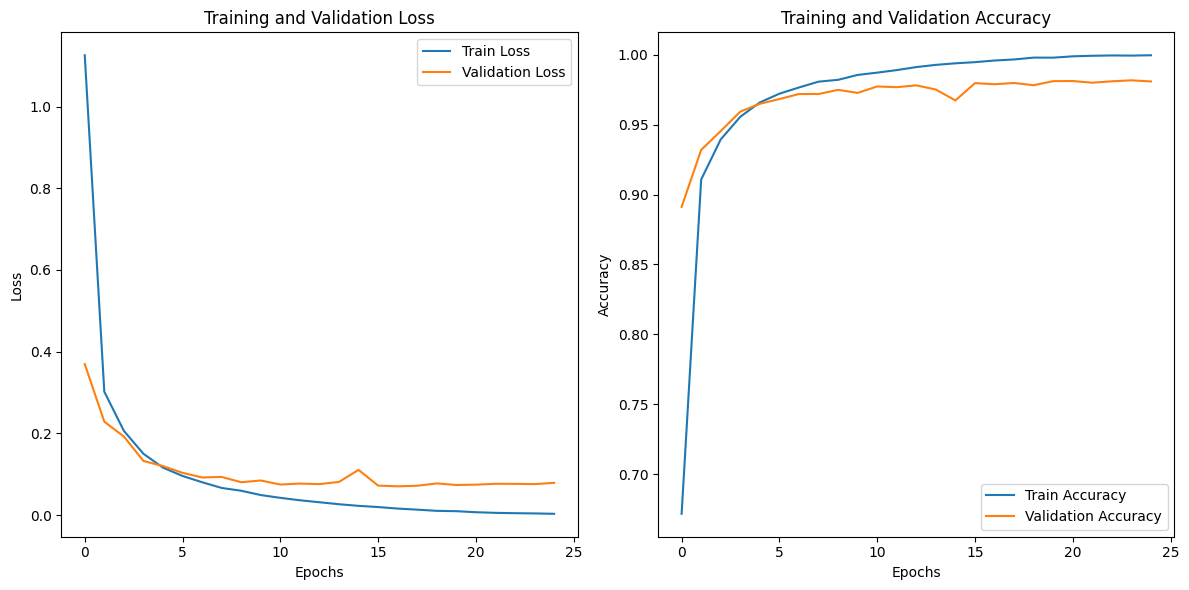

Best accuracy: 0.9818


Training with layers: [256, 128, 64, 64]


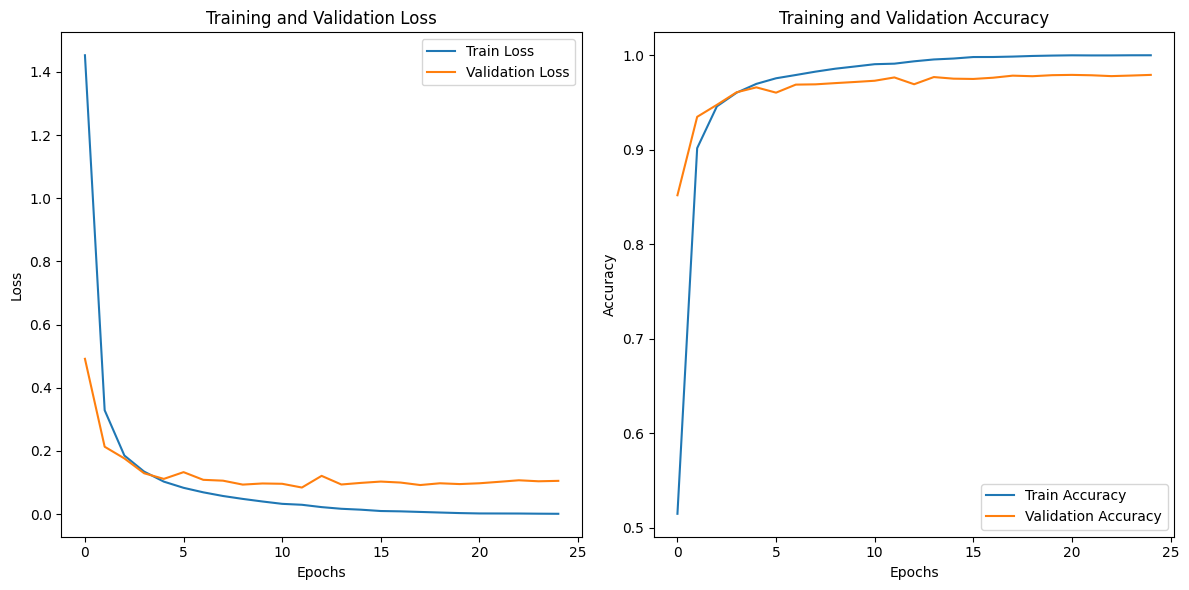

Best accuracy: 0.9792


Training with layers: [512, 256, 128, 64, 64]


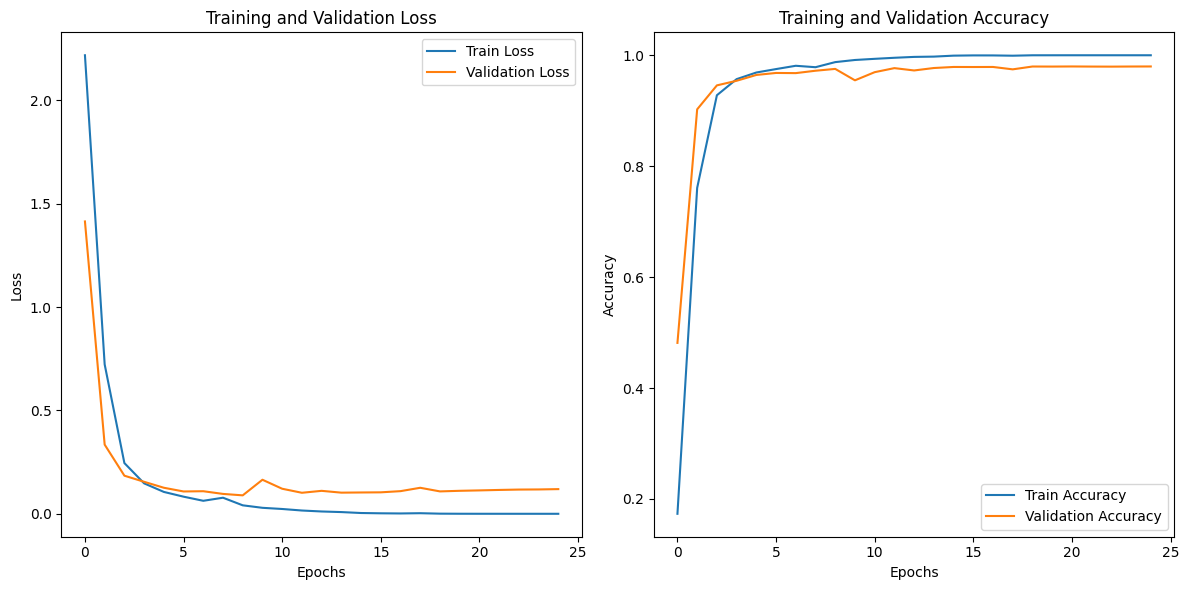

Best accuracy: 0.9798


Training with layers: [256, 128]


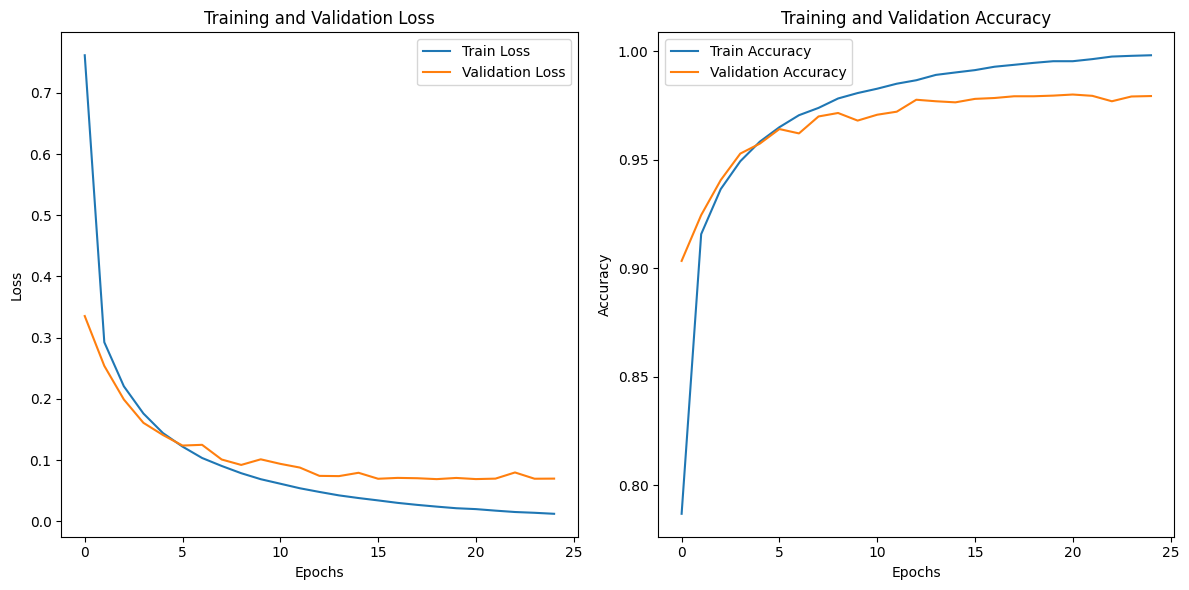

Best accuracy: 0.98



Best number of layers:
number of layers: 3, Validation Accuracy: 0.9818


In [92]:
batch_size=128
results = {}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
layers=[[256,128,64],[256,128,64,64],[512,256,128,64,64],[256,128]]
for i in range(len(layers)):
    network = FeedForwardNN(layers[i])
    print(f"Training with layers: {layers[i]}")
    train_losses,train_accuracies,val_losses,val_accuracies = train_network(network,train_loader,val_loader,torch.optim.SGD(network.parameters(), lr=best_lr),nn.CrossEntropyLoss())
    plot_metrics(train_losses,train_accuracies,val_losses,val_accuracies)
    best_val_accuracy = max(val_accuracies)
    print(f"Best accuracy: {best_val_accuracy}\n\n")
    results[i] = best_val_accuracy
best_layer = max(results, key=results.get)

print("\nBest number of layers:")
print(f"number of layers: {len(layers[best_layer])}, Validation Accuracy: {results[best_layer]:.4f}")

Training with layers: [256, 128, 64]


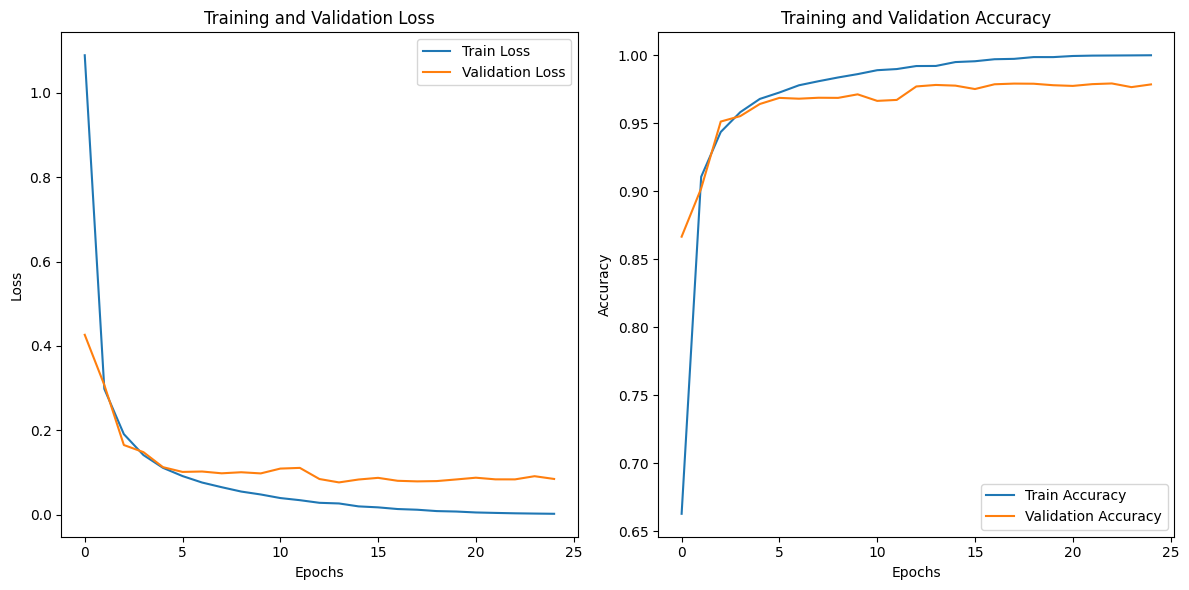

Best accuracy: 0.9791


Training with layers: [64, 64, 64]


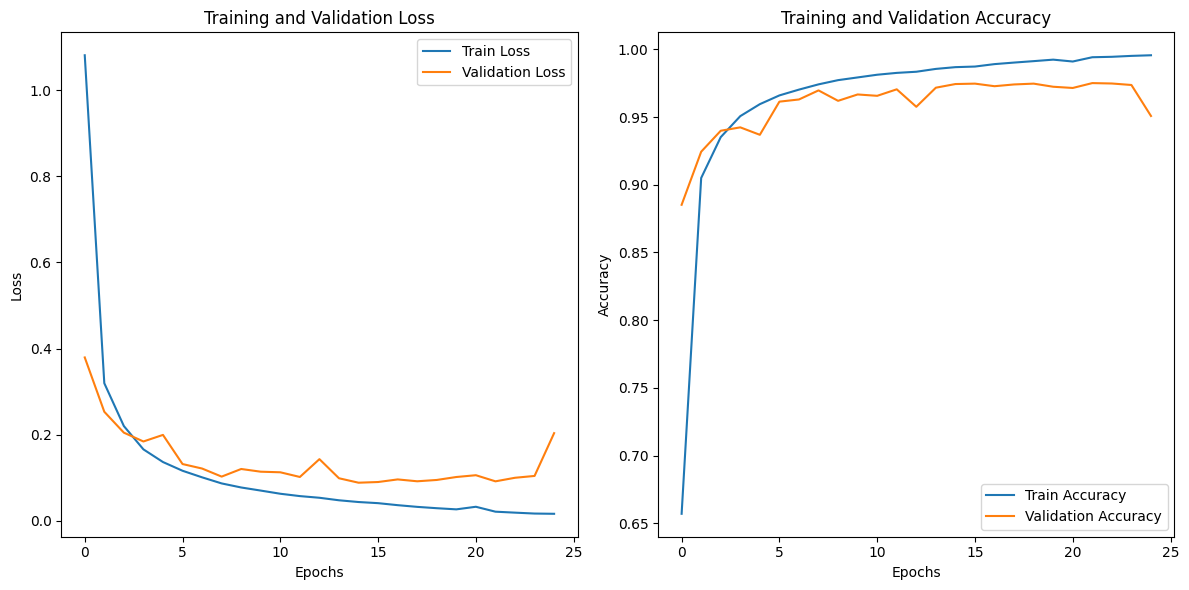

Best accuracy: 0.9751


Training with layers: [128, 64, 32]


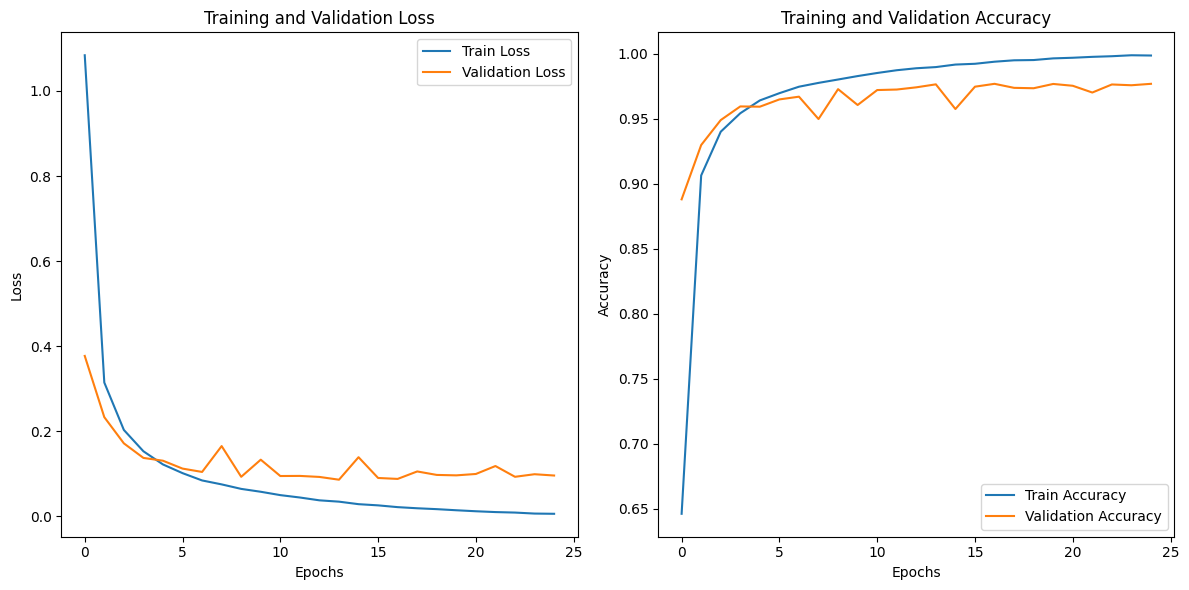

Best accuracy: 0.977


Training with layers: [1024, 512, 128]


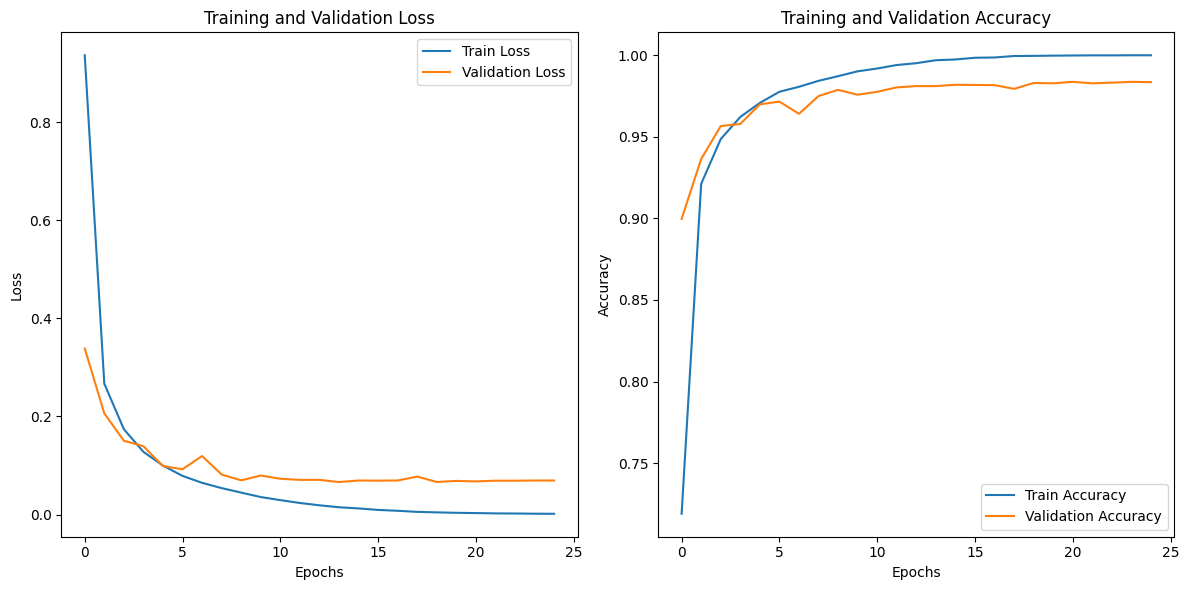

Best accuracy: 0.9837



Best neurons per layer:
neurons: [1024, 512, 128], Validation Accuracy: 0.9837


In [96]:
batch_size=128
results = {}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
layers=[[256,128,64],[64,64,64],[128,64,32],[1024,512,128]]
best_network=None
best_val_accuracy = 0
for i in range(len(layers)):
    network = FeedForwardNN(layers[i])
    print(f"Training with layers: {layers[i]}")
    train_losses,train_accuracies,val_losses,val_accuracies = train_network(network,train_loader,val_loader,torch.optim.SGD(network.parameters(), lr=best_lr),nn.CrossEntropyLoss())
    plot_metrics(train_losses,train_accuracies,val_losses,val_accuracies)
    current_best_val_accuracy = max(val_accuracies)
    print(f"Best accuracy: {current_best_val_accuracy}\n\n")
    results[i] = current_best_val_accuracy
if current_best_val_accuracy > best_val_accuracy:
    best_val_accuracy = current_best_val_accuracy
    best_network = network
best_layer = max(results, key=results.get)

print("\nBest neurons per layer:")
print(f"neurons: {layers[best_layer]}, Validation Accuracy: {results[best_layer]:.4f}")

##### Tuning number of hidden layers and number of neurons per layer:
- loss and accuracy are calculated at each epoch for multiple layer shapes on training data and then optimizations are made
- loss and accuracy are calculated at each epoch for multiple layer shapes on validation data to check generalization
- the network with best validation accuracy is selected to be used on test data  

Test Accuracy: 98.07%

Confusion Matrix:


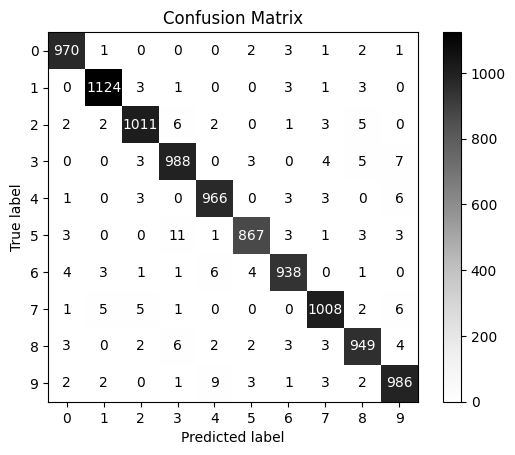

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

best_network.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        outputs = best_network(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

test_accuracy = (correct / total)*100
print(f"Test Accuracy: {test_accuracy:.2f}%\n")

cm = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap=plt.cm.Greys)
plt.title("Confusion Matrix")
plt.show()


#### Conclusion:
After tuning the different hyperparameters and selecting the model with the best performance,the model is used to predict the test data which results in a prediction accuracy of 98.07% and the above Confusion Matrix